При подготовке ноутбука использовались материалы:
1. [LDA topic modelling lenta Kaggle](https://www.kaggle.com/genyagree/lda-topic-modelling/notebook)
2. [LDA topic modelling visualization](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
3. [LDA topic modelling](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

# Введение
**Latent Dirichlet Allocation** (LDA) - статистическая модель, позволяющая разделить набор текстов на $N$ подгрупп.

Каждый кластер характеризуется набором из $X$ ключевых слов. Эти ключевые слова ассоциируются с темой (topic). 

Каждый документ может быть представлен абором тем, каждая тема может быть представлена набором ключевых слов.

### Пример
У нас есть 3 документа:<br>
<br>
D1 = "Собаки любят играть"<br>
D2 = "Кошки любят молоко"<br>
D3 = "Кошки и собаки любят кушать и играть. Я люблю собак. Они милые"<br>

Topic Modelling может выдать следующую модель:<br>
<br>
D1 = 100% Topic1 + 0% Topic2<br>
D2 = 0% Topic1 + 100% Topic2<br>
D3 = 70% Topic1 + 30% Topic2<br>
<br>
Где каждая тема сформирована из слов (в порядке убывания значимости):<br>
<br>
Topic1 = 30% собака, 30% играть, 20% нравиться 10% милая 10% любить<br>
Topic2 = 50% кошка, 30% молоко, 20% нравиться<br>



# Зачем нужно LDA Topic Modeling

Общая задача тематического моделирования - обнаружение скрытой структуры в наборе текстовых данных. 
Для маленького количества текстов мы могли бы использовать просто tf-idf информацию, но для большого числа документов этого уже не достаточно

Практические применения:

1. [Суммаризация мнений](https://dl.acm.org/doi/10.1145/1076034.1076161)
Управляющим организациям, чьи решения влияют на большие группы людей может быть полезно суммаризовать информацию с выражением мнений из открытых источников (постов и комментариев в соцсетях)

2. [Bioinformatics](https://springerplus.springeropen.com/articles/10.1186/s40064-016-3252-8)
Применение метода к "microarray datasets" - датасетам с последовательностями аминокилот или нуклеотидов - для выявления сткрытой структуры этих данных.

3. [Отслеживание трендов в тематиках корпусов текстов](https://timreview.ca/article/1170)
Анализ корпуса текстов - научных публикаций на определенную тему - позволяет отследить, как меняется взгляд на ту или иную научную проблему

4. [Рекомендательные системы](https://habr.com/ru/company/surfingbird/blog/150607/)
Если представить пользователя как набор описания продуктов, которые ему понравились, то можно находить тематики, интересующие пользователя и делать рекомендации в соответствии с ними.



   
# Немного теории
В latent diriclet allocaton (LDA) модели каждый документ в корпусе представляется в виде набора тем в соответствии с распределением Дирихле.

##  Постановка проблемы
- Коллекция документов $D$
- Каждый документ $d$ из коллекции представлен набором слов $W_{d} = (w_{1}, ..., w_{n_{d}})$ из словаря $W$, где $n_{d}$ - длина документа $d$
- Каждому документу соответствует набор тем
- Порядком слов в документе пренебрегают: каждый документ рассматривается как bag-of-words
- Каждая тема $t\in T$ (где $T$ - набор тем) описывается распределением Дирихле $p(w|t)$ на наборе слов $w\in W$, то есть тема представлена в виде вектора $\phi_{t} = (p(w|t):w \in W)$
- Каждый документ $d\in D$ описывается распределением Дирихле $p(t|d)$ на наборе тем $t\in T$. То есть документ описывается вектором $\theta_{d} = (p(t|d):t \in T)$
<br>

![](https://editor.analyticsvidhya.com/uploads/26864dtm.JPG)

Вероятность "возникновения" пары "документ-слово" можно записать следующим образом:

$$
p(w|d)=\sum\limits_{t\in T}p(w|t)p(t|d)
$$

![](https://miro.medium.com/max/780/1*QiTvyHNwvGI5UCqeKvhNsg.png)

## Решение
Построить модель тематического моделирования значит найти матрицы $\Phi = ||p(w|t)||$ и $\Theta = ||p(t|d)||$ на основе коллекции документов $D$.


Для нахождения решения нужно ршеить оптимизационную задачу - максимизировать следующую функцию (максимизируем likelihood наших данных с такими матрицами): 
$$
\sum\limits_{d\in D}\sum\limits_{w\in d}n_{dw}logp(w|d)\to\max\limits_{\Phi,\Theta},
$$
где $n_{dw}$ - частота слова $w$ в документе $d$.

In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
import json
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
%matplotlib inline
import nltk
import pymorphy2
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

C:\Users\melom\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Загрузка данных

In [2]:
DATA_DIR = "data"
DATA_FILE = "lenta-ru-news.csv"

In [3]:
rus_data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE)).dropna()

C:\Users\melom\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
rus_data.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [5]:
rus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712654 entries, 0 to 739175
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     712654 non-null  object
 1   title   712654 non-null  object
 2   text    712654 non-null  object
 3   topic   712654 non-null  object
 4   tags    712654 non-null  object
 5   date    712654 non-null  object
dtypes: object(6)
memory usage: 38.1+ MB


In [6]:
rus_data['topic'].value_counts()

Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

## Чистка данных

In [7]:
def clean_data(df):
    rusdata_df = df[(df['topic']!='Библиотека')&(df['topic']!='Бывший СССР')&(df['topic']!='69-я параллель')].reset_index(drop=True).sample(10000, random_state = 42)
    rusdata = rusdata_df['text']
    return rusdata_df, rusdata

In [8]:
rusdata_df, rusdata = clean_data(rus_data)

In [9]:
rusdata

47040     На одном из заводов в городе Салфит на Западно...
47827     Госсекретарь США Колин Пауэлл вновь встретился...
437317    МТС предложила сократить срок эмбарго на строи...
155505    Экс-чемпион мира по боксу Константин Цзю посту...
580672    Народный художник России, кинодекоратор Алекса...
                                ...                        
389799    Руководство американской газеты USA Today попр...
295325    Папу Римского Бенедикта XVI толкнула паломница...
152201    Михаил Фрадков назначил нового заместителя рук...
518313    Посетитель кладбища в районе Вены Хернальс Ман...
270969    В Санкт-Петербурге умер народный артист России...
Name: text, Length: 10000, dtype: object

# Обработка данных

1. Удаление стоп-слов
2. Токенизация
2. Лемматизация
3. Построение словаря n-грамм
4. Tf-idf кодирование

 ## Удаление стоп-слов

1. Стоп-слова из библиотеки nltk
2. Дополнительный набор стоп-слов №1 ([github](https://github.com/stopwords-iso/stopwords-ru))
3. Дополнительный набор стоп-слов №2 ([github](https://github.com/Alir3z4/stop-words))

In [10]:
STOPWORDS_DIR = "stopwords"

In [14]:
import nltk
nltk.download('stopwords')

def get_stop_words():
    stopwordsrus = list(stopwords.words('russian'))
    with open(os.path.join(STOPWORDS_DIR, "russian.txt")) as f:
        stop_words_1 = f.read().split("\n")
    with open(os.path.join(STOPWORDS_DIR, "stopwords-ru.txt")) as f:
        stop_words_2 = f.read().split("\n")
    return list(set(stopwordsrus+stop_words_1+stop_words_2))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\melom\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [15]:
stopwordsru = get_stop_words()

### Токенизация

In [18]:
nltk.download('punkt')

def process(text):
    return list(t.lower() for t in word_tokenize(text) if t.isalpha() and t.lower() not in stopwordsru)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\melom\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [19]:
data = [process(t) for t in rusdata]

## Лемматизация

In [20]:
morph = pymorphy2.MorphAnalyzer()
def lemmatizer(texts):
    return [[morph.parse(word)[0] for word in text] for text in texts]

In [21]:
morph_data = lemmatizer(data)

In [22]:
def extract_lemma(texts):
    norm = []
    for t in texts:
        res = []
        for word in t:
            n = word.normal_form
            res.append(n)
        norm.append(res)
    return norm

In [23]:
# This is our lemmatized data ready to be used further:
data_norm = extract_lemma(morph_data)

# Визуализация

In [24]:
def wordcloud_visualization(list_of_tokenized_sentences):
    # Join the different processed titles together.
    long_string = ','.join([','.join(x) for x in list_of_tokenized_sentences])

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

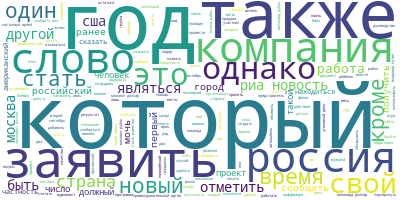

In [25]:
wordcloud_visualization(data_norm)

## Построение n-грамм

*Смотри документацию [Phrases](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phrases) и [Phraser](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.FrozenPhrases). Phraser ускоряет работу Phrases*

In [26]:
bigram = gensim.models.Phrases(data_norm, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_norm], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [27]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_trigrams = make_trigrams(data_norm)

In [28]:
print(data_words_trigrams[0])

['один', 'завод', 'город', 'салфита', 'западный_берег', 'израильский', 'военный', 'обнаружить', 'называть', 'пояс_шахид', 'предназначить', 'совершение_теракт', 'посредством', 'самоубийство', 'сообщать', 'издание', 'сведение', 'израильский', 'спецслужба', 'исламский', 'экстремист', 'подготовить', 'около', 'сто', 'который', 'планироваться', 'направить', 'иерусалим', 'данные', 'ряд', 'источник', 'финансировать', 'подобный', 'процесс', 'подготовка', 'теракт', 'мочь', 'структура', 'базироваться', 'саудовский_аравия', 'агентство', 'выяснить', 'накануне', 'саудовский_аравия', 'счёт', 'семья', 'самоубийца', 'джамаль', 'нассера', 'поступить', 'тысяча', 'доллар', 'именно', 'человек', 'совершить', 'теракт', 'район', 'наблус', 'врезаться', 'автобус', 'машина', 'загрузить', 'взывчатка', 'подобный', 'платёж', 'семья', 'погибнуть', 'палестинский', 'террорист', 'регулярно', 'проходить', 'саудовский_аравия', 'утверждать', 'источник', 'среда', 'министр_внутренний', 'дело', 'саудовский_аравия', 'найефа',

## Создание словаря n-gram и BOW

*Смотри документацию [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary) и [doc2bow](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow).*

In [29]:
dictionary = corpora.Dictionary(data_words_trigrams)

corpus = [dictionary.doc2bow(doc) for doc in data_words_trigrams]
# We will also try to filter unimportant words by their tf-idf score, so let's create the tf-idf scores here too


In [30]:
dictionary[8]

'взывчатка'

## Encoding Tf-Idf

TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)

[Статья с хорошим описанием](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089)

$t$ — term (word)<br>
$d$ — document (set of words)<br>
$D$ - коллекция документов<br>
$N$ — размер коллекции документов $D$<br>


$$tf(t,d) = \frac{n_{td}}{n_{d}}$$
Частота встречаемости слова в документе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$df(t) = \sum_d{n_{td}}$$
Встречаемость слова в корпусе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$idf(t) = log(\frac{N}{df(t)+1})$$
Обратная встречаемость слова в корпусе.<br>
<br>

**$$tfidf(t,d) = tf(t,d)*idf(t)$$**

In [31]:
tfidf = gensim.models.TfidfModel(corpus, id2word = dictionary)

# Построение модели LDA Topic Modelling

## Использование корпуса без TF-IDF фильтрации

In [40]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
pprint(lda_model.show_topics(formatted=False))

[(37,
  [('причаститься', 1.5513013e-05),
   ('подоходный', 1.5513013e-05),
   ('цапп', 1.5513013e-05),
   ('хартмут', 1.5513013e-05),
   ('фрайбург', 1.5513013e-05),
   ('раскаяние', 1.5513013e-05),
   ('будить', 1.5513013e-05),
   ('посреднический', 1.5513013e-05),
   ('загс', 1.5513013e-05),
   ('миропомазание', 1.5513013e-05)]),
 (8,
  [('причаститься', 1.5513013e-05),
   ('подоходный', 1.5513013e-05),
   ('цапп', 1.5513013e-05),
   ('хартмут', 1.5513013e-05),
   ('фрайбург', 1.5513013e-05),
   ('раскаяние', 1.5513013e-05),
   ('будить', 1.5513013e-05),
   ('посреднический', 1.5513013e-05),
   ('загс', 1.5513013e-05),
   ('миропомазание', 1.5513013e-05)]),
 (69,
  [('причаститься', 1.5513013e-05),
   ('подоходный', 1.5513013e-05),
   ('цапп', 1.5513013e-05),
   ('хартмут', 1.5513013e-05),
   ('фрайбург', 1.5513013e-05),
   ('раскаяние', 1.5513013e-05),
   ('будить', 1.5513013e-05),
   ('посреднический', 1.5513013e-05),
   ('загс', 1.5513013e-05),
   ('миропомазание', 1.5513013e-05)

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame (index=range(10000), columns = ['Dominant_Topic1', 'Dominant_Topic2', '%Topic_Contribution1', '%Topic_Contribution2', 'Topic_Keywords1', 'Topic_Keywords2'])
    
    # Get main topic in each document
    for i, text in enumerate(ldamodel[corpus]):
        text = text[0]
        text = sorted(text, key=lambda x: x[1], reverse=True) #sort % contributions of topic  
        # Get the Dominant topic, % of topic contribution and Keywords for each document
        for j, (topic_num, topic_contrib) in enumerate(text):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic1[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution1'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords1'][i] = topic_keywords
                
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            elif j == 1:  # => second dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic2[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution2'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords2'][i] = topic_keywords
                
            else:
                break
    

    # Add original text to the end of the output
    contents = pd.Series(texts, name = "text")
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=rusdata.values)


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,9,29,0.1459,0.1448,"теракт, семья, террорист, призвать, подготовка...","который, свой, время, это, один, сообщать, одн...",На одном из заводов в городе Салфит на Западно...
1,0,19,0.2201,0.1718,"россия, также, российский, слово, заявить, ран...","пятница, час, утром, превысить, скорее, милици...",Госсекретарь США Колин Пауэлл вновь встретился...
2,20,29,0.2931,0.0842,"связь, международный, помощь, предложить, усло...","который, свой, время, это, один, сообщать, одн...",МТС предложила сократить срок эмбарго на строи...
3,0,40,0.1522,0.1396,"россия, также, российский, слово, заявить, ран...","украина, европейский, европа, германия, постав...",Экс-чемпион мира по боксу Константин Цзю посту...
4,0,64,0.1268,0.0804,"россия, также, российский, слово, заявить, ран...","история, роман, посвятить, старый, памятник, к...","Народный художник России, кинодекоратор Алекса..."
5,12,29,0.3133,0.0829,"счёт, минута, победа, чемпионат, мяч, удар, фо...","который, свой, время, это, один, сообщать, одн...","Мадридский ""Реал"" обеспечил себе победу в чемп..."
6,0,16,0.1237,0.1113,"россия, также, российский, слово, заявить, ран...","комплекс, русский, премия, журнал, институт, н...",Бюджетный комитет федерального парламента Герм...
7,22,0,0.2074,0.1392,"автомобиль, машина, рабочий, водитель, принадл...","россия, также, российский, слово, заявить, ран...",Продажи нового бюджетного седана Nissan Almera...
8,32,56,0.206,0.1145,"решение, суд, право, бывший, адвокат, признать...","год, новый, первый, стать, являться, конец, на...","Двое американцев, занимавшихся мошенничеством ..."
9,0,36,0.3561,0.0761,"россия, также, российский, слово, заявить, ран...","правительство, проект, руководитель, государст...",Более четверти бывших министров администрации ...


,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,9,29,0.1459,0.1448,"теракт, семья, террорист, призвать, подготовка...","который, свой, время, это, один, сообщать, одн...",На одном из заводов в городе Салфит на Западно...
1,0,19,0.2201,0.1718,"россия, также, российский, слово, заявить, ран...","пятница, час, утром, превысить, скорее, милици...",Госсекретарь США Колин Пауэлл вновь встретился...
2,20,29,0.2931,0.0842,"связь, международный, помощь, предложить, усло...","который, свой, время, это, один, сообщать, одн...",МТС предложила сократить срок эмбарго на строи...
3,0,40,0.1522,0.1396,"россия, также, российский, слово, заявить, ран...","украина, европейский, европа, германия, постав...",Экс-чемпион мира по боксу Константин Цзю посту...
4,0,64,0.1268,0.0804,"россия, также, российский, слово, заявить, ран...","история, роман, посвятить, старый, памятник, к...","Народный художник России, кинодекоратор Алекса..."
5,12,29,0.3133,0.0829,"счёт, минута, победа, чемпионат, мяч, удар, фо...","который, свой, время, это, один, сообщать, одн...","Мадридский ""Реал"" обеспечил себе победу в чемп..."
6,0,16,0.1237,0.1113,"россия, также, российский, слово, заявить, ран...","комплекс, русский, премия, журнал, институт, н...",Бюджетный комитет федерального парламента Герм...
7,22,0,0.2074,0.1392,"автомобиль, машина, рабочий, водитель, принадл...","россия, также, российский, слово, заявить, ран...",Продажи нового бюджетного седана Nissan Almera...
8,32,56,0.206,0.1145,"решение, суд, право, бывший, адвокат, признать...","год, новый, первый, стать, являться, конец, на...","Двое американцев, занимавшихся мошенничеством ..."
9,0,36,0.3561,0.0761,"россия, также, российский, слово, заявить, ран...","правительство, проект, руководитель, государст...",Более четверти бывших министров администрации ...


In [ ]:
df_dominant_topic.loc[1]["text"]

'МТС предложила сократить срок эмбарго на строительство сетей стандарта связи LTE в Краснодарском крае для тех операторов, которые не являются партнерами Олимпийских игр в Сочи, пишет «Коммерсантъ». Эмбарго предлагается отменить в конце 2014 года, тогда как сейчас оно действует до декабря 2016 года. МТС направила соответствующее письмо в Минсвязи. Компания отмечает, что является лидером по количеству абонентов в крае и ограничение на строительство новых сетей рассматривает как несправедливое. Как передает издание, 2 июля комиссия по радиочастотам (ГКРЧ) может рассмотреть сокращение срока эмбарго, но решение будет отрицательным, поскольку против этого выступил Роскомнадзор. Кроме того, решение установлено федеральным законом, так что у ГКРЧ может не оказаться полномочий, чтобы его отменить. Услуги в ходе Олимпиады могут оказывать «МегаФон» и «Ростелеком», являющиеся ее генеральными партнерами. В других же компаниях решение об эмбарго до конца 2016 года считают «технической ошибкой», пос

'МТС предложила сократить срок эмбарго на строительство сетей стандарта связи LTE в Краснодарском крае для тех операторов, которые не являются партнерами Олимпийских игр в Сочи, пишет «Коммерсантъ». Эмбарго предлагается отменить в конце 2014 года, тогда как сейчас оно действует до декабря 2016 года. МТС направила соответствующее письмо в Минсвязи. Компания отмечает, что является лидером по количеству абонентов в крае и ограничение на строительство новых сетей рассматривает как несправедливое. Как передает издание, 2 июля комиссия по радиочастотам (ГКРЧ) может рассмотреть сокращение срока эмбарго, но решение будет отрицательным, поскольку против этого выступил Роскомнадзор. Кроме того, решение установлено федеральным законом, так что у ГКРЧ может не оказаться полномочий, чтобы его отменить. Услуги в ходе Олимпиады могут оказывать «МегаФон» и «Ростелеком», являющиеся ее генеральными партнерами. В других же компаниях решение об эмбарго до конца 2016 года считают «технической ошибкой», пос

In [ ]:
df_dominant_topic.loc[2]["Topic_Keywords1"]

'связь, международный, помощь, предложить, условие, три, автор, неделя, план, направить'

'связь, международный, помощь, предложить, условие, три, автор, неделя, план, направить'

In [ ]:
df_dominant_topic.to_csv('./results/dominant_topic_no_tfidf_limit.csv', index= False)

## Визуализация

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_no_tfidf_limits')

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_news_no_tfidf_limits' +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.286246  0.219640       1        1  15.136596
29     0.270835  0.250052       2        1  11.497995
56     0.245828 -0.031412       3        1   6.126605
53     0.243716  0.022526       4        1   6.068807
67     0.216763  0.088392       5        1   4.714676
...         ...       ...     ...      ...        ...
33    -0.149137  0.032236      76        1   0.184852
15    -0.228672  0.033939      77        1   0.007539
69    -0.231230  0.033426      78        1   0.003437
37    -0.231230  0.033426      79        1   0.003416
8     -0.231230  0.033426      80        1   0.003403

[80 rows x 5 columns], topic_info=            Term          Freq         Total Category  logprob  loglift
180          год  25732.000000  25732.000000  Default  30.0000  30.0000
39       который  17810.000000  17810.000000  Default  29.0000  29.0000
1243     процент   5007.000000   5007.000000  Default  28.0000  28.0000
197     компания   5673.000000   5673.000000  Default  27.0000  27.0000
320       россия   9906.000000   9906.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
24     журналист      0.000617   1641.743828  Topic80 -11.0738  -4.5058
25         завод      0.000617    437.913550  Topic80 -11.0738  -3.1843
26     загрузить      0.000617     35.215029  Topic80 -11.0738  -0.6637
27    заниматься      0.000617   1068.670567  Topic80 -11.0738  -4.0764
29      заявлять      0.000617    407.027775  Topic80 -11.0738  -3.1111

[2990 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4452     17  0.990476            a
3883     56  0.913102     abc_news
3095     28  0.995554          afp
430      30  0.996362       agence
4202     63  0.966782          all
...     ...       ...          ...
849       3  0.970998       январь
651      13  0.996945       япония
909       3  0.996251     японский
2116     41  0.952791    ярославль
119      47  0.957590  ясир_арафат

[2393 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 30, 57, 54, 68, 4, 21, 37, 80, 33, 7, 22, 74, 24, 73, 76, 56, 15, 45, 58, 64, 69, 62, 52, 18, 6, 32, 47, 41, 44, 72, 20, 31, 13, 28, 40, 27, 49, 75, 50, 53, 26, 71, 55, 2, 17, 10, 3, 51, 67, 25, 39, 79, 14, 60, 42, 8, 77, 12, 11, 23, 65, 19, 59, 46, 35, 78, 29, 61, 63, 36, 43, 5, 66, 48, 34, 16, 70, 38, 9])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.286246  0.219640       1        1  15.136596
29     0.270835  0.250052       2        1  11.497995
56     0.245828 -0.031412       3        1   6.126605
53     0.243716  0.022526       4        1   6.068807
67     0.216763  0.088392       5        1   4.714676
...         ...       ...     ...      ...        ...
33    -0.149137  0.032236      76        1   0.184852
15    -0.228672  0.033939      77        1   0.007539
69    -0.231230  0.033426      78        1   0.003437
37    -0.231230  0.033426      79        1   0.003416
8     -0.231230  0.033426      80        1   0.003403

[80 rows x 5 columns], topic_info=            Term          Freq         Total Category  logprob  loglift
180          год  25732.000000  25732.000000  Default  30.0000  30.0000
39       который  17810.000000  17810.000000  Default  29.0000  29.0000
1243     процент   5007.000000   5007.000000  Default  28.0000  28.0000
197     компания   5673.000000   5673.000000  Default  27.0000  27.0000
320       россия   9906.000000   9906.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
24     журналист      0.000617   1641.743828  Topic80 -11.0738  -4.5058
25         завод      0.000617    437.913550  Topic80 -11.0738  -3.1843
26     загрузить      0.000617     35.215029  Topic80 -11.0738  -0.6637
27    заниматься      0.000617   1068.670567  Topic80 -11.0738  -4.0764
29      заявлять      0.000617    407.027775  Topic80 -11.0738  -3.1111

[2990 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4452     17  0.990476            a
3883     56  0.913102     abc_news
3095     28  0.995554          afp
430      30  0.996362       agence
4202     63  0.966782          all
...     ...       ...          ...
849       3  0.970998       январь
651      13  0.996945       япония
909       3  0.996251     японский
2116     41  0.952791    ярославль
119      47  0.957590  ясир_арафат

[2393 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 30, 57, 54, 68, 4, 21, 37, 80, 33, 7, 22, 74, 24, 73, 76, 56, 15, 45, 58, 64, 69, 62, 52, 18, 6, 32, 47, 41, 44, 72, 20, 31, 13, 28, 40, 27, 49, 75, 50, 53, 26, 71, 55, 2, 17, 10, 3, 51, 67, 25, 39, 79, 14, 60, 42, 8, 77, 12, 11, 23, 65, 19, 59, 46, 35, 78, 29, 61, 63, 36, 43, 5, 66, 48, 34, 16, 70, 38, 9])

# Оценка качества

### Perplexity

[Подробное описание](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94)


Оценка генеративной языковой модели.

Мы хотим, чтобы наша языковая модель приписывала высокие вероятности реальным предложениям и низкие - нереальным. Поэтому чем ниже PP, тем лучше.


$PP(W)$ - обратная вероятность тестового корпуса слов, нормированная на его размер

$$PP(W) = \frac1{P(w_1,...,w_N)^{\frac1N}}$$


In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.


Perplexity:  -36.368284176484735


# Задание

## Использование корпуса c TF-IDF фильтрацией (10 баллов)

TFIDF коэффициенты выделяют слова, которые являются часто употребимыми (не несут информации о конкретном документе) или те, которые встречаются только в одном документе и не могут показать скрытую связь между документами. 

В этом задании нужно
1. Найти максимальное и минимальное значение tfidf скора

*Подсказка*: нужно проитерироваться по всему корпусу слов, посчитать tfidf скор и найти пороговые значения

2. Построить дискретный массив tfidf скоров с шагом 0.005 и найти перцентили 10 и 95

3. Отфильтровать corpus в filtered_corpus, оставив только слова со скорами, попадающими в диапазон от 10 до 95 перцентилей.
4. Построить подель LDA на отфильтрованном корпусе
5. Посчитать метрики качества
5. Сделать визуализацию тематик
6. Посмотреть на темы с наибольшими коэффициентами в датафрейме
7. Напишите, какой вывод можно сделать

**Комментарий** - можно уменьшать количество  $n_topics$, если вашему компьютеру не хватает вычислительных мощностей.

**Комментарий** - если при визуализации вы получили ошибку `TypeError: Object of type complex is not JSON serializable`, добавьте в метод `prepare` аргумент `mds='mmds'`

In [49]:
#1
tfid_max = max([max([value for id, value in tfidf[corpus[x]]]) for x in range(len(corpus))])
tfid_min = min([min([value for id, value in tfidf[corpus[x]]]) for x in range(len(corpus))])

In [52]:
#2
tfidf_scores = [x for x in np.arange(tfid_min, tfid_max, 0.005)]

In [53]:
#3
lower_bound = np.percentile(tfidf_scores, 10)
higher_bound = np.percentile(tfidf_scores, 95)
filtered_corpus = []
for i in range(len(corpus)):
    filtered_corpus.append([(id, value) for (id, value) in tfidf[corpus[i]] if lower_bound <= value <= higher_bound])

In [54]:
#4
lda_model = gensim.models.ldamodel.LdaModel(corpus=filtered_corpus,
                                           id2word=dictionary,
                                           num_topics=80,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [55]:
#5
print('\nPerplexity: ', lda_model.log_perplexity(filtered_corpus))


Perplexity:  -162.84608459472202


In [56]:
#6
LDAvis_prepared = gensimvis.prepare(lda_model, filtered_corpus, dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_news_no_tfidf_limits' +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=         x    y  topics  cluster  Freq
topic                                 
0      0.0  0.0       1        1  1.25
1      0.0  0.0       2        1  1.25
58     0.0  0.0       3        1  1.25
57     0.0  0.0       4        1  1.25
56     0.0  0.0       5        1  1.25
...    ...  ...     ...      ...   ...
25     0.0  0.0      76        1  1.25
24     0.0  0.0      77        1  1.25
23     0.0  0.0      78        1  1.25
22     0.0  0.0      79        1  1.25
79     0.0  0.0      80        1  1.25

[80 rows x 5 columns], topic_info=                 Term      Freq     Total Category  logprob  loglift
0             автобус  0.000000  0.000000  Default  30.0000     30.0
42979          будить  0.000000  0.000000  Default  29.0000     29.0
42966       венчаться  0.000000  0.000000  Default  28.0000     28.0
42967            загс  0.000000  0.000000  Default  27.0000     27.0
42968    исповедаться  0.000000  0.000000  Default  26.0000     26.0
...               ...       ...       ...      ...      ...      ...
25              завод  0.006944  0.555546  Topic80 -11.0738     -0.0
26          загрузить  0.006944  0.555546  Topic80 -11.0738     -0.0
27         заниматься  0.006944  0.555546  Topic80 -11.0738     -0.0
28     западный_берег  0.006944  0.555546  Topic80 -11.0738     -0.0
29           заявлять  0.006944  0.555546  Topic80 -11.0738     -0.0

[2430 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 60, 61, 62, 72, 79, 78, 77, 76, 75, 74, 73, 71, 63, 70, 69, 68, 67, 66, 65, 64, 42, 41, 40, 11, 18, 17, 16, 15, 14, 13, 12, 10, 20, 9, 8, 7, 6, 5, 4, 3, 19, 21, 39, 31, 38, 37, 36, 35, 34, 33, 32, 30, 22, 29, 28, 27, 26, 25, 24, 23, 80])

In [64]:
#7
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=filtered_corpus, texts=rusdata.values)

df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,0,1,0.0125,0.0125,"причаститься, подоходный, цапп, хартмут, фрайб...","причаститься, подоходный, цапп, хартмут, фрайб...",На одном из заводов в городе Салфит на Западно...
1,0,1,0.0125,0.0125,"причаститься, подоходный, цапп, хартмут, фрайб...","причаститься, подоходный, цапп, хартмут, фрайб...",Госсекретарь США Колин Пауэлл вновь встретился...
2,0,1,0.0125,0.0125,"причаститься, подоходный, цапп, хартмут, фрайб...","причаститься, подоходный, цапп, хартмут, фрайб...",МТС предложила сократить срок эмбарго на строи...
3,0,1,0.0125,0.0125,"причаститься, подоходный, цапп, хартмут, фрайб...","причаститься, подоходный, цапп, хартмут, фрайб...",Экс-чемпион мира по боксу Константин Цзю посту...
4,0,1,0.0125,0.0125,"причаститься, подоходный, цапп, хартмут, фрайб...","причаститься, подоходный, цапп, хартмут, фрайб...","Народный художник России, кинодекоратор Алекса..."
5,0,1,0.0125,0.0125,"причаститься, подоходный, цапп, хартмут, фрайб...","причаститься, подоходный, цапп, хартмут, фрайб...","Мадридский ""Реал"" обеспечил себе победу в чемп..."
6,0,1,0.0125,0.0125,"причаститься, подоходный, цапп, хартмут, фрайб...","причаститься, подоходный, цапп, хартмут, фрайб...",Бюджетный комитет федерального парламента Герм...
7,0,1,0.0125,0.0125,"причаститься, подоходный, цапп, хартмут, фрайб...","причаститься, подоходный, цапп, хартмут, фрайб...",Продажи нового бюджетного седана Nissan Almera...
8,0,1,0.0125,0.0125,"причаститься, подоходный, цапп, хартмут, фрайб...","причаститься, подоходный, цапп, хартмут, фрайб...","Двое американцев, занимавшихся мошенничеством ..."
9,0,1,0.0125,0.0125,"причаститься, подоходный, цапп, хартмут, фрайб...","причаститься, подоходный, цапп, хартмут, фрайб...",Более четверти бывших министров администрации ...


In [65]:
df_dominant_topic.loc[1]["text"]

'Госсекретарь США Колин Пауэлл вновь встретился с премьер-министром Израиля Ариэлем Шароном. Как   сообщает Ha\'aretz, встреча состоялась в Иерусалиме. Подробности неизвестны. Пауэлл отсрочил  свой отъезд из региона на 24 часа. В среду утром у него запланирована встреча с Ясиром Арафатом, а затем он вылетит в Каир на переговоры с египетскими официальными лицами для консультаций по итогам его переговоров с палестинцами и израильтянами, сообщает Reuters. Пауэлл заявил, что он доволен переговорами. По его словам, в целом он настроен оптимистично, но итоги могут оказаться не совсем такими, как ожидалось. Прекращения огня, скорее всего, достичь не удастся. "Мы достигли прогресса, и я ожидаю еще большего прогресса в ближайшие 24 часа. Но я не хотел бы вдаваться в детали относительно того, чего я могу и чего не могу достичь", - заявил он.'

#8
Изменений особо нет, всё те же доменантные темы.

## Дополнительное задание (5 баллов)

Постройте LDA Topic modelling модель для [датасета постов о политике с Пикабу](https://www.kaggle.com/atomin/pikabu-politic-posts). 

При построении можете поизменять параметры `alpha` и `beta` для получения более качественной модели.

Какие выводы можно сделать на основе полученной модели?

In [ ]:

tf_max = #YOUR_CODE
tf_min = #YOUR_CODE
print(tf_max, tf_min)
tfidf_range = #YOUR_CODE

print(np.percentile(tfidf_range, 95), np.percentile(tfidf_range, 10))

In [38]:
low_value = np.percentile(tfidf_range, 10) 
high_value = np.percentile(tfidf_range, 95) 

filtered_corpus = []
for i in range(0, len(corpus)):
        
    filter_ids = #YOUR_CODE
   
    new_bow = #YOUR_CODE
      
    filtered_corpus.append(new_bow)

In [82]:
lda_model_tfidf = #YOUR_CODE

In [83]:
# Show Topics
pprint(lda_model_tfidf.show_topics(formatted=False))

[(34,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802e-05),
   ('слэш', 1.5475802e-05),
   ('валентайна', 1.5475802e-05),
   ('velvet', 1.5475802e-05),
   ('trick', 1.5475802e-05),
   ('стивить', 1.5475802e-05),
   ('slash', 1.5475802e-05),
   ('alter', 1.5475802e-05),
   ('cheap', 1.5475802e-05)]),
 (44,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802e-05),
   ('слэш', 1.5475802e-05),
   ('валентайна', 1.5475802e-05),
   ('velvet', 1.5475802e-05),
   ('trick', 1.5475802e-05),
   ('стивить', 1.5475802e-05),
   ('slash', 1.5475802e-05),
   ('alter', 1.5475802e-05),
   ('cheap', 1.5475802e-05)]),
 (13,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802e-05),
   ('слэш', 1.5475802e-05),
   ('валентайна', 1.5475802e-05),
   ('velvet', 1.5475802e-05),
   ('trick', 1.5475802e-05),
   ('стивить', 1.5475802e-05),
   ('slash', 1.5475802e-05),
   ('alter', 1.5475802e-05),
   ('cheap', 1.5475802e-05)]),
 (52,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802

In [86]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_with_tfidf')

LDAvis_prepared = #YOUR_CODE
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_with_no_tfidf' +'.html')
LDAvis_prepared

C:\ProgramData\Anaconda3\envs\topic_modelling_2\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
41     0.427692  0.033073       1        1  3.315873
5      0.183917  0.309363       2        1  3.124598
22     0.325356  0.270014       3        1  3.114157
1     -0.367516 -0.063728       4        1  2.701882
73     0.223593 -0.273546       5        1  2.673219
...         ...       ...     ...      ...       ...
39    -0.006156 -0.000034      76        1  0.074927
44    -0.006157 -0.000034      77        1  0.074724
56    -0.006156 -0.000034      78        1  0.074724
34    -0.006156 -0.000033      79        1  0.074724
57    -0.006155 -0.000033      80        1  0.074724

[80 rows x 5 columns], topic_info=                Term         Freq        Total Category  logprob  loglift
1241         процент  7802.000000  7802.000000  Default  30.0000  30.0000
105              сша  3780.000000  3780.000000  Default  29.0000  29.0000
420            фильм  3243.000000  3243.000000  Default  28.0000  28.0000
196         компания  3166.000000  3166.000000  Default  27.0000  27.0000
1184         украина  3134.000000  3134.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
21            доллар     0.004568  2323.281522  Topic80 -11.0762  -5.9402
22            житель     0.004568   282.399070  Topic80 -11.0762  -3.8328
24             завод     0.004568  1095.923466  Topic80 -11.0762  -5.1888
27    западный_берег     0.004568    45.708513  Topic80 -11.0762  -2.0118
29         иерусалим     0.004568   264.539310  Topic80 -11.0762  -3.7675

[2901 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4446     67  0.915896            a
649      21  0.297061          aol
1515      5  0.985309     bbc_news
4523     15  0.791765          bmw
1300     11  0.967785       boeing
...     ...       ...          ...
3742      2  0.941114        юноша
3545     27  0.963340         юрий
3875     59  0.783533   юрисдикция
1882     48  0.963344        юрист
118      25  0.945216  ясир_арафат

[724 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[42, 6, 23, 2, 74, 44, 69, 13, 79, 4, 71, 78, 48, 47, 24, 31, 66, 19, 15, 65, 27, 68, 25, 60, 54, 67, 18, 26, 11, 37, 64, 50, 76, 72, 63, 10, 12, 51, 73, 36, 43, 46, 41, 28, 75, 8, 5, 16, 21, 59, 62, 49, 33, 1, 34, 70, 20, 32, 29, 30, 55, 56, 17, 77, 52, 38, 9, 80, 7, 22, 61, 3, 39, 53, 14, 40, 45, 57, 35, 58])

In [ ]:
print('\nPerplexity: ', #YOUR_CODE)  

In [ ]:
df_topic_sents_keywords = #YOUR_CODE


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

In [92]:
df_dominant_topic.to_csv('./results/dominant_topic_with_tfidf_limit.csv', index= False)

In [ ]:
df_dominant_topic.loc[2]["text"]

In [ ]:
df_dominant_topic.loc[2]["Topic_Keywords2"]